In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load dataset
df = pd.read_csv("/content/predictive_maintenance.csv")

# Menampilkan informasi dan distribusi target
print(f"Shape: {df.shape}")
print(f"Target distribution: {df['Target'].value_counts().to_dict()}")
print(f"Failure types: {df['Failure Type'].value_counts().to_dict()}")


Shape: (10000, 10)
Target distribution: {0: 9661, 1: 339}
Failure types: {'No Failure': 9652, 'Heat Dissipation Failure': 112, 'Power Failure': 95, 'Overstrain Failure': 78, 'Tool Wear Failure': 45, 'Random Failures': 18}


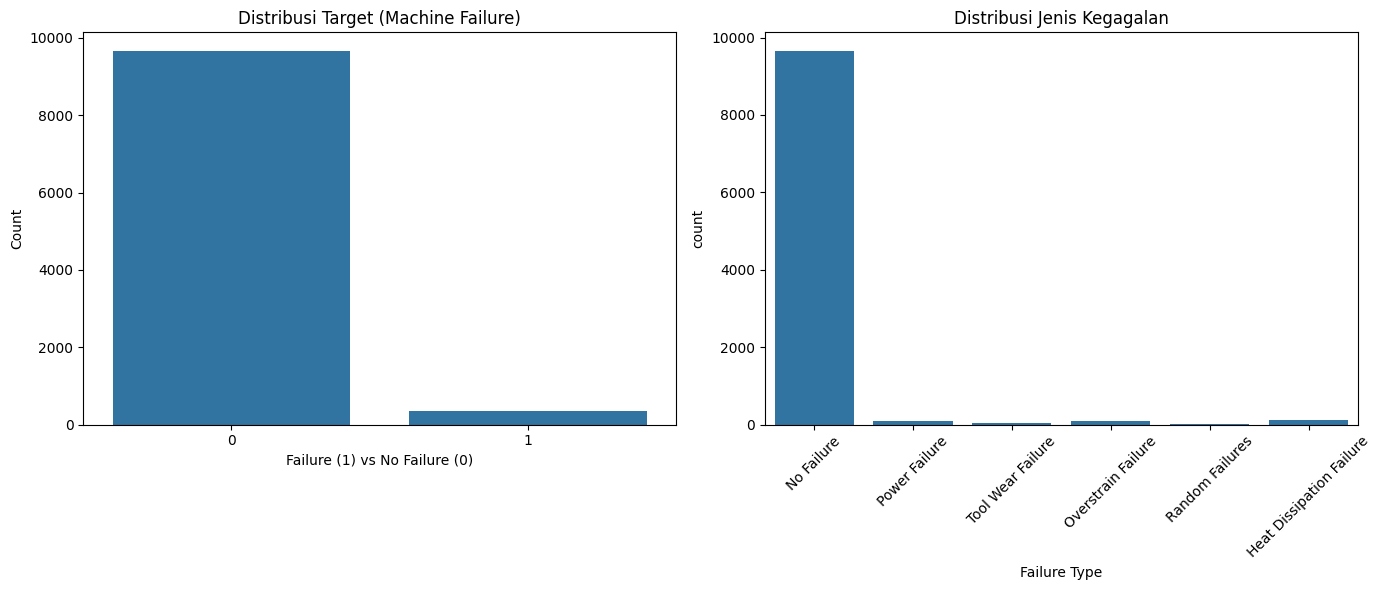

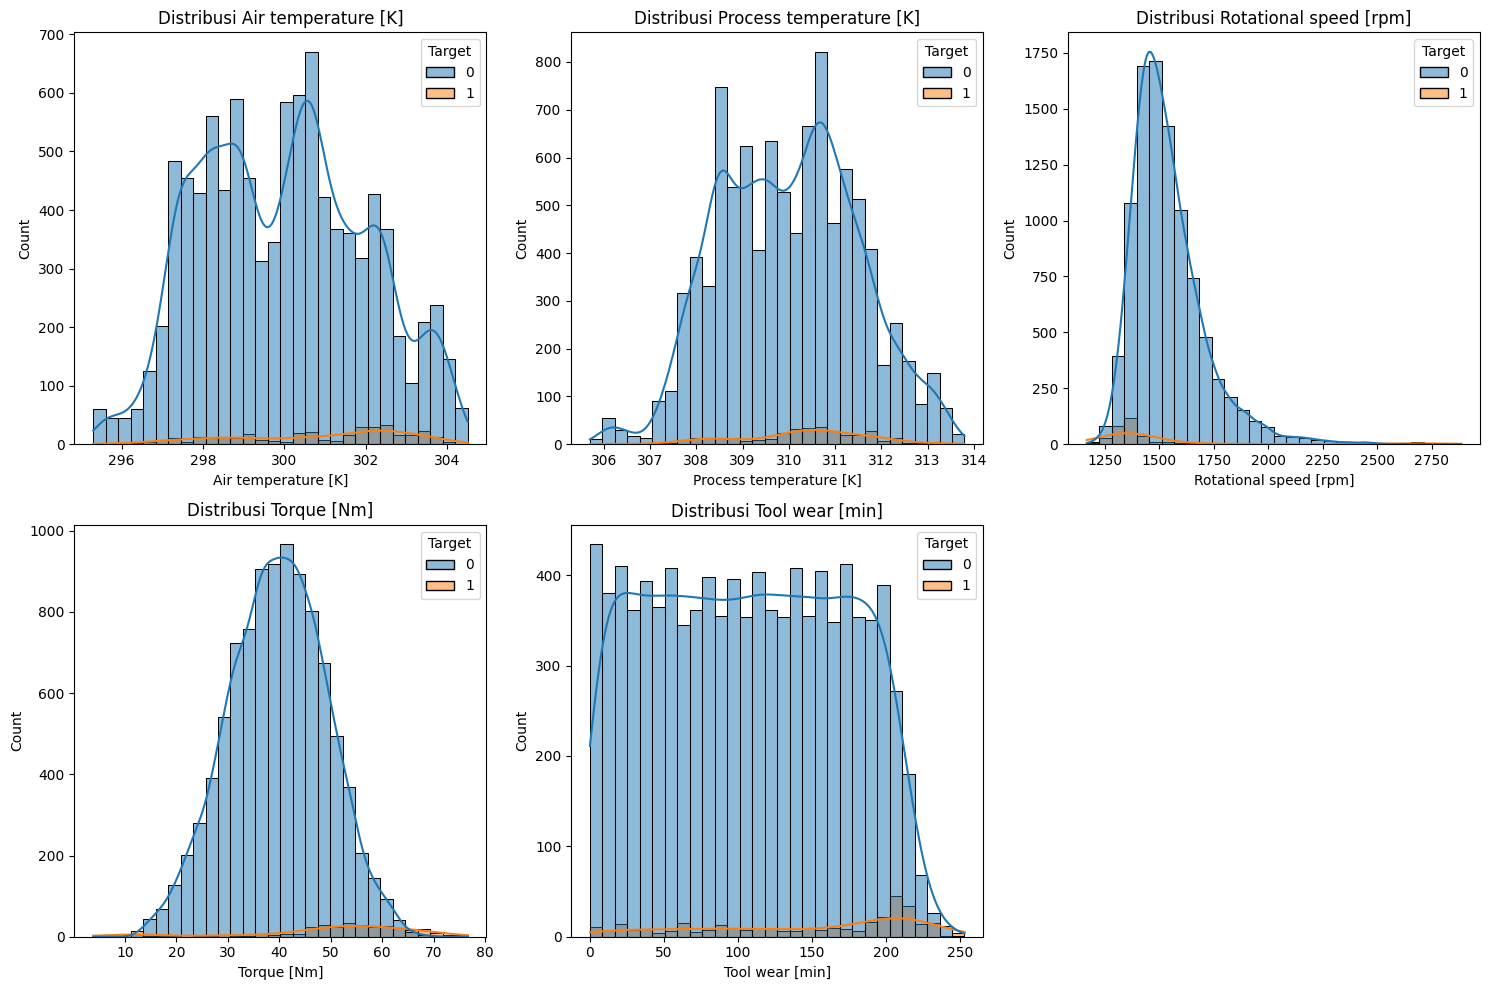

In [ ]:
# Visualisasi distribusi target
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.countplot(x='Target', data=df)
plt.title('Distribusi Target (Machine Failure)')
plt.xlabel('Failure (1) vs No Failure (0)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x='Failure Type', data=df)
plt.title('Distribusi Jenis Kegagalan')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualisasi fitur numerik berdasarkan target
numerical_features = ['Air temperature [K]', 'Process temperature [K]',
                     'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df, x=feature, hue='Target', kde=True, bins=30)
    plt.title(f'Distribusi {feature}')
plt.tight_layout()
plt.show()


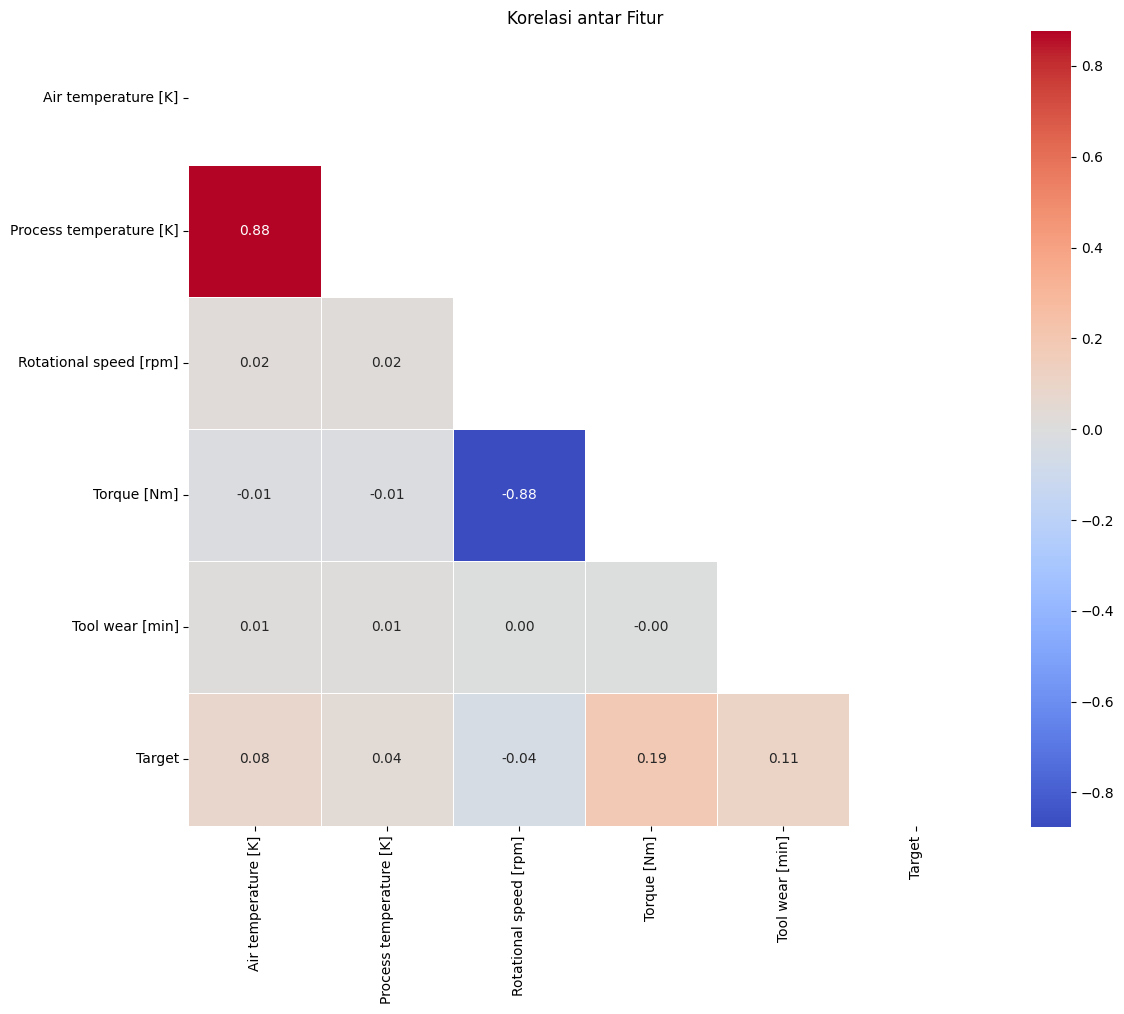

In [ ]:
# Visualisasi korelasi
plt.figure(figsize=(12, 10))
corr = df[numerical_features + ['Target']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, linewidths=.5)
plt.title('Korelasi antar Fitur')
plt.tight_layout()
plt.show()


In [ ]:
# Feature engineering
def preprocess_data(df):
    # Buat salinan dataframe
    df_processed = df.copy()

    # Hapus kolom yang tidak digunakan untuk model
    df_processed = df_processed.drop(['UDI', 'Product ID'], axis=1)

    # One-hot encoding untuk fitur kategorikal
    df_processed = pd.get_dummies(df_processed, columns=['Type'], drop_first=False)

    # Buat beberapa fitur baru yang mungkin berguna
    df_processed['Temp_Difference'] = df_processed['Process temperature [K]'] - df_processed['Air temperature [K]']
    df_processed['Power'] = df_processed['Rotational speed [rpm]'] * df_processed['Torque [Nm]'] / 9.5488  # Power in Watts

    # Pisahkan fitur dan target
    X = df_processed.drop(['Target', 'Failure Type'], axis=1)
    y_binary = df_processed['Target']
    y_multiclass = df_processed['Failure Type']

    return X, y_binary, y_multiclass, df_processed

# Preprocessing data
X, y_binary, y_multiclass, df_processed = preprocess_data(df)

# Split data menjadi training dan testing
X_train, X_test, y_train_binary, y_test_binary, y_train_multi, y_test_multi = train_test_split(
    X, y_binary, y_multiclass, test_size=0.2, random_state=42, stratify=y_binary)


In [ ]:
# Handle imbalanced data dengan SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_binary_resampled = smote.fit_resample(X_train, y_train_binary)

print("Distribusi target sebelum resampling:", pd.Series(y_train_binary).value_counts())
print("Distribusi target setelah resampling:", pd.Series(y_train_binary_resampled).value_counts())


Distribusi target sebelum resampling: Target
0    7729
1     271
Name: count, dtype: int64
Distribusi target setelah resampling: Target
0    7729
1    7729
Name: count, dtype: int64


=== Random Forest Binary Evaluation ===
Accuracy: 0.9750
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1932
           1       0.61      0.74      0.67        68

    accuracy                           0.97      2000
   macro avg       0.80      0.86      0.83      2000
weighted avg       0.98      0.97      0.98      2000



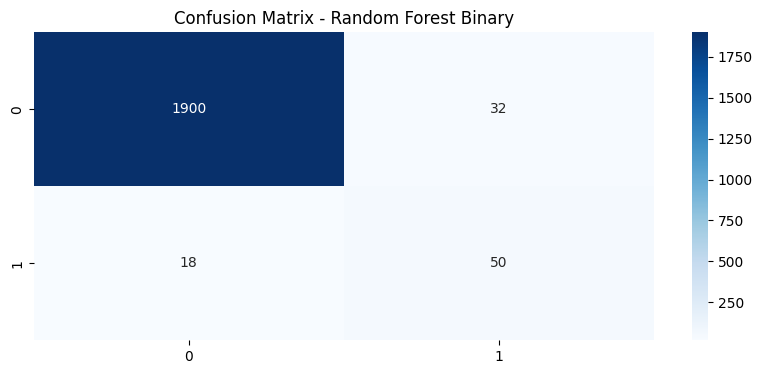

=== XGBoost Binary Evaluation ===
Accuracy: 0.9155
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1932
           1       0.27      0.85      0.41        68

    accuracy                           0.92      2000
   macro avg       0.63      0.89      0.68      2000
weighted avg       0.97      0.92      0.94      2000



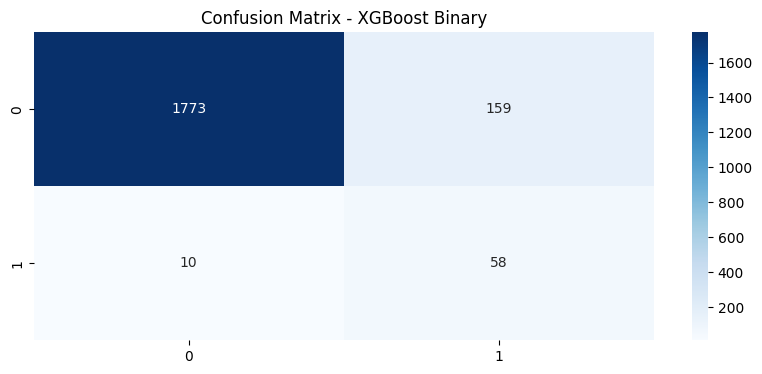

In [ ]:
# Fungsi untuk menghapus karakter ilegal dari nama kolom (untuk XGBoost)
def clean_column_names(df):
    df = df.copy()
    df.columns = df.columns.str.replace(r'[\[\]<>]', '', regex=True)
    return df

# Fungsi untuk mengevaluasi model binary
def evaluate_binary_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # Pastikan nama kolom bersih jika menggunakan XGBoost
    if 'XGB' in model.__class__.__name__:
        X_train = clean_column_names(X_train)
        X_test = clean_column_names(X_test)
    # Fit model
    model.fit(X_train, y_train)
    # Prediksi
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    # Evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f"=== {model_name} Evaluation ===")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    # Confusion Matrix
    plt.figure(figsize=(10, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    return model, accuracy, y_pred_proba

# Random Forest untuk klasifikasi biner
rf_binary = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model, rf_accuracy, rf_proba = evaluate_binary_model(
    rf_binary, X_train_resampled, y_train_binary_resampled, X_test, y_test_binary, "Random Forest Binary"
)

# XGBoost untuk klasifikasi biner
xgb_binary = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    scale_pos_weight=len(y_train_binary[y_train_binary==0])/len(y_train_binary[y_train_binary==1])
)
xgb_model, xgb_accuracy, xgb_proba = evaluate_binary_model(
    xgb_binary, X_train_resampled, y_train_binary_resampled, X_test, y_test_binary, "XGBoost Binary"
)


In [ ]:
def clean_column_names(df):
    df = df.copy()
    df.columns = df.columns.str.replace(r'[\[\]<>]', '', regex=True)
    return df

# Bersihkan nama kolom sebelum GridSearchCV
X_train_resampled_clean = clean_column_names(X_train_resampled)
X_test_clean = clean_column_names(X_test)


Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200}
=== Optimized XGBoost Evaluation ===
Accuracy: 0.9790
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.66      0.79      0.72        68

    accuracy                           0.98      2000
   macro avg       0.83      0.89      0.85      2000
weighted avg       0.98      0.98      0.98      2000



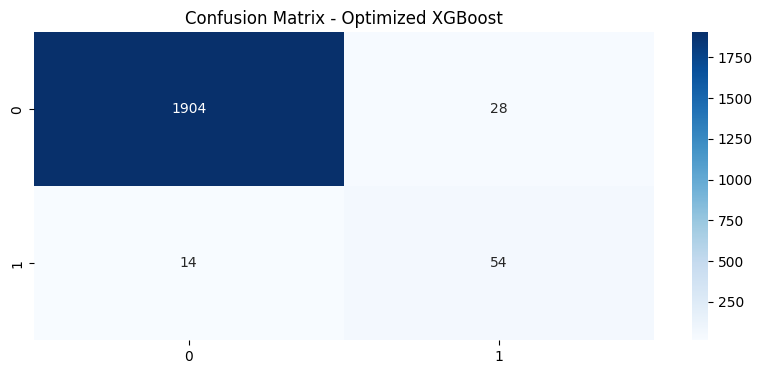

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

# Gunakan DataFrame dengan nama kolom yang sudah bersih
grid_search.fit(X_train_resampled_clean, y_train_binary_resampled)
print("Best parameters:", grid_search.best_params_)

# Evaluasi model dengan parameter terbaik
best_model = grid_search.best_estimator_
best_model, best_accuracy, best_proba = evaluate_binary_model(
    best_model, X_train_resampled_clean, y_train_binary_resampled, X_test_clean, y_test_binary, "Optimized XGBoost"
)


In [ ]:
# Filter data kegagalan untuk model multiclass
failure_idx_train = y_train_binary == 1
X_train_failure = X_train[failure_idx_train]
y_train_failure = y_train_multi[failure_idx_train]

failure_idx_test = y_test_binary == 1
X_test_failure = X_test[failure_idx_test]
y_test_failure = y_test_multi[failure_idx_test]

# Random Forest untuk klasifikasi multikelas
rf_multi = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
if len(X_train_failure) > 0 and len(np.unique(y_train_failure)) > 1:
    rf_multi.fit(X_train_failure, y_train_failure)
    y_pred_multi = rf_multi.predict(X_test_failure)
    print("Multiclass Classification Report:")
    print(classification_report(y_test_failure, y_pred_multi))


Multiclass Classification Report:
                          precision    recall  f1-score   support

Heat Dissipation Failure       1.00      1.00      1.00        28
              No Failure       1.00      0.50      0.67         2
      Overstrain Failure       0.88      1.00      0.94        15
           Power Failure       1.00      1.00      1.00        13
       Tool Wear Failure       1.00      0.90      0.95        10

                accuracy                           0.97        68
               macro avg       0.98      0.88      0.91        68
            weighted avg       0.97      0.97      0.97        68



In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from imblearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

# Fitur numerik dan kategorik
numeric_features = ['Air temperature [K]', 'Process temperature [K]',
                    'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
categorical_features = ['Type']

# Transformer untuk numerik dan kategorik
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])

# Gabungkan preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Pipeline lengkap dengan SMOTE
model_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb.XGBClassifier(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    ))
])

# Pisahkan data
X = df.drop(['UDI', 'Product ID', 'Target', 'Failure Type'], axis=1)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Latih model
model_pipeline.fit(X_train, y_train)

# Evaluasi
y_pred = model_pipeline.predict(X_test)
print("Pipeline Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Pipeline Model Accuracy: 0.9565
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1932
           1       0.43      0.84      0.57        68

    accuracy                           0.96      2000
   macro avg       0.71      0.90      0.77      2000
weighted avg       0.97      0.96      0.96      2000



In [ ]:
# Ambil nama fitur dari preprocessor
onehot_feature_names = model_pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'].named_steps['onehot'] \
    .get_feature_names_out(categorical_features)

numeric_feature_names = numeric_features  # Tetap sama

# Gabungkan semua nama fitur setelah preprocessing
all_feature_names = np.concatenate([numeric_feature_names, onehot_feature_names])


In [ ]:
importances = model_pipeline.named_steps['classifier'].feature_importances_


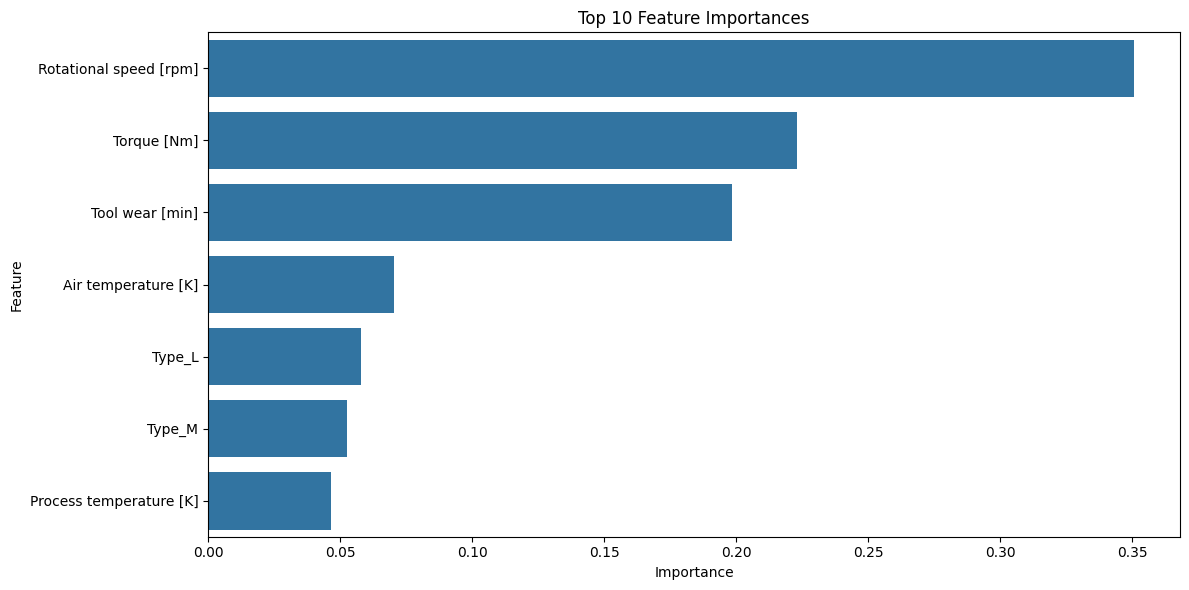

In [ ]:
feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()


In [ ]:
# Simpan model
import joblib
joblib.dump(model_pipeline, 'machine_failure_prediction_model.pkl')

# Fungsi untuk prediksi
def predict_failure(model, data):
    failure_prob = model.predict_proba(data)[:, 1]
    predicted_failure = model.predict(data)

    result = pd.DataFrame({
        'Failure_Probability': failure_prob,
        'Predicted_Failure': predicted_failure
    })

    return result

# Contoh penggunaan
sample_data = X.head(15)
prediction_result = predict_failure(model_pipeline, sample_data)
print("Prediksi untuk 15 data teratas:")
display(pd.concat([sample_data.reset_index(drop=True), prediction_result], axis=1))


Prediksi untuk 15 data teratas:


,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Failure_Probability,Predicted_Failure
0,M,298.1,308.6,1551,42.8,0,0.001010,0
1,L,298.2,308.7,1408,46.3,3,0.004997,0
2,L,298.1,308.5,1498,49.4,5,0.001534,0
3,L,298.2,308.6,1433,39.5,7,0.002215,0
4,L,298.2,308.7,1408,40.0,9,0.001980,0
5,M,298.1,308.6,1425,41.9,11,0.003124,0
6,L,298.1,308.6,1558,42.4,14,0.001937,0
7,L,298.1,308.6,1527,40.2,16,0.001937,0
8,M,298.3,308.7,1667,28.6,18,0.002410,0
9,M,298.5,309.0,1741,28.0,21,0.002635,0


In [ ]:
import joblib

model_pipeline = joblib.load('/content/machine_failure_prediction_model.pkl')

import pandas as pd

raw_df = pd.read_csv('/content/predictive_maintenance.csv')  # Ganti dengan path file asli jika belum dibaca

def predict_failure(model, data):
    failure_prob = model.predict_proba(data)[:, 1]
    predicted_failure = model.predict(data)

    result = pd.DataFrame({
        'Failure_Probability': failure_prob,
        'Predicted_Failure': predicted_failure
    })
    return result

prediction_result = predict_failure(model_pipeline, raw_df)
final_result = pd.concat([raw_df.reset_index(drop=True), prediction_result], axis=1)
display(final_result.head(20))


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,Failure_Probability,Predicted_Failure
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure,0.001010,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure,0.004997,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure,0.001534,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure,0.002215,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure,0.001980,0
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,No Failure,0.003124,0
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,No Failure,0.001937,0
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,No Failure,0.001937,0
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,No Failure,0.002410,0
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,No Failure,0.002635,0


In [ ]:
# # 1. Muat model pipeline
# import joblib
# model_pipeline = joblib.load('machine_failure_prediction_model.pkl')

# # 2. Muat dataset mentah
# import pandas as pd
# raw_df = pd.read_csv('/content/predictive_maintenance.csv')  # Ganti path sesuai kebutuhan

# # 3. Filter berdasarkan tipe mesin, contoh semua yang dimulai dengan "M"
# filtered_df = raw_df[raw_df['Product ID'].str.startswith('M')].copy()

# # 4. Fungsi prediksi
# def predict_failure(model, data):
#     failure_prob = model.predict_proba(data)[:, 1]
#     predicted_failure = model.predict(data)
#     return pd.DataFrame({
#         'Failure_Probability': failure_prob,
#         'Predicted_Failure': predicted_failure
#     })

# # 5. Lakukan prediksi
# prediction_result = predict_failure(model_pipeline, filtered_df)

# # 6. Gabungkan hasil dengan data asli
# final_result = pd.concat([filtered_df.reset_index(drop=True), prediction_result], axis=1)

# # 7. Tampilkan
# print("Hasil prediksi untuk tipe mesin yang dimulai dengan 'M':")
# display(final_result.head(30))
